# Dependencies

In [27]:
import MURA
import cv2
import image_manipulation
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing
import json
from os import path, mkdir

import keras
from argparse import ArgumentParser
import tensorflow as tf
from sklearn import metrics
import re
from scipy.optimize import brentq


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-06-12 20:50:15.991174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-12 20:50:15.991216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: epictetus.emperor-bebop.ts.net
2023-06-12 20:50:15.991228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: epictetus.emperor-bebop.ts.net
2023-06-12 20:50:15.991328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.116.4
2023-06-12 20:50:15.991358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.116.4
2023-06-12 20:50:15.991369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.116.4


# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [2]:
# All editable variables
model_file_path = "models/model_1_UPAE"
# If preprocessing needs to run
load_model = False

In [3]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    dataset_file_path = params['dataset_path']

except:
    raise Exception("No parameters.json file found in the model's directory.")

In [5]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

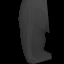

In [6]:
from PIL import Image
image = Image.fromarray(image_datasets["train"][10])
display(image)


# Model Training
This section creates and trains the model

In [8]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
        print("VAE")
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)
        print("UPAE")

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    model.summary()
    
    if load_model:
        model.load_weights(model_file_path + '/model_weights')
    else:
        np.random.shuffle(image_datasets['train'])

        validation_split = 0.05

        total_samples = len(image_datasets['train'])
        validation_samples = int(validation_split * total_samples)

        train_data = image_datasets['train'][:-validation_samples]
        validation_data = image_datasets['train'][-validation_samples:]

        # Where images of each epoch will be saved
        save_directory = model_file_path + '/callback_images'
        save_callback = SaveImageCallback(validation_data, save_directory=save_directory, vae=model_is_VAE)

   
        history_train = model.fit(train_data, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                validation_data=(validation_data, validation_data),
                                callbacks=[save_callback])

        # Saving the model's history
        json.dump(history_train.history, open(model_file_path + '/history.json', 'w'))

        #Save weights
        model.save_weights(model_file_path + '/model_weights', save_format='tf')
    

Model: "encoder_decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 16, 16, 128) 

# Creating of different Plots

In [9]:
# Create directory for saving images
save_directory = model_file_path + '/plots'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


In [10]:
# Get history of data
history = history_train.history

def create_plot(history, metric, title, save_name):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.savefig(f'{save_directory}/{save_name}', dpi=300)
    plt.close()

# Check if UPAE or not
if model_is_VAE:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for reconstruction_loss
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for kl_loss
    create_plot(history, 'kl_loss', 'KL Loss per Epoch', 'kl_loss.png')
else:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for total loss
    create_plot(history, 'total_loss', 'Total Loss per Epoch', 'total_loss.png')
    # Create plot for loss1
    create_plot(history, 'loss1', 'Loss 1 per Epoch', 'loss1.png')
    # Create plot for loss2
    create_plot(history, 'loss2', 'Loss 2 per Epoch', 'loss2.png')
    # Create plot for binary_crossentropy
#     create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
#     # Create plot for accuracy
#     create_plot(history, 'accuracy', 'Accuracy per Epoch', 'accuracy.png')
    

# Testing of the Model with the Test Set
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [11]:
# Get labels of each image in the image_datasets['test']
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [12]:
history_valid = model.predict(test_images, batch_size=batch_size)

In [14]:
abnor_scores = history_valid[1]
#converting to an array of numbers instead of tensor
abnor_scores = [item.numpy() for item in abnor_scores if isinstance(item, tf.Tensor)]
abnor_scores = [float(item) for item in abnor_scores]

In [15]:
auc = metrics.roc_auc_score(labels, abnor_scores)

In [16]:
#Getting roc_curve output
fpr, tpr, thresholds = metrics.roc_curve(labels, abnor_scores)
idx = None

#Computation for the threshold
for i in range(len(fpr)):
    fnr = 1 - tpr[i]
    if abs(fpr[i] - fnr) <= 5e-3:
        idx = i
        break
assert idx is not None
t = thresholds[idx]

#using threshold t , will be used to classify abnormality scores as normal or abnormal in the y_pred array;
y_pred = np.zeros_like(labels)
y_pred[abnor_scores < t] = 0
y_pred[abnor_scores >= t] = 1



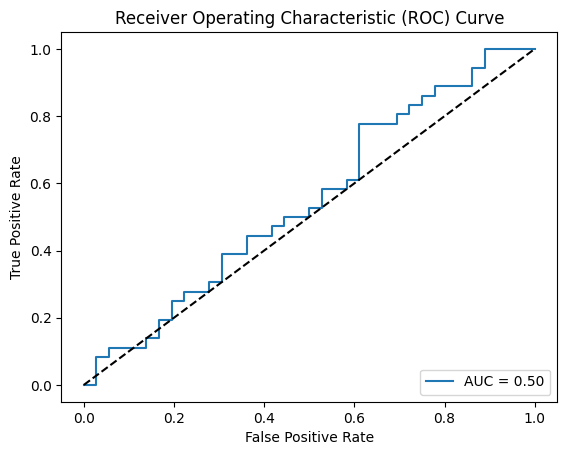

In [34]:
auc = metrics.roc_auc_score(labels, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(model_file_path+'/plots/roc_curve.png')



#ROC AUC Curve interpretation
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [29]:

# getting metrics score using y_pred which is now either 0  or 1

pres = metrics.precision_score(labels, y_pred)
sens = metrics.recall_score(labels, y_pred, pos_label=1)
spec = metrics.recall_score(labels, y_pred, pos_label=0)
f1 = metrics.f1_score(labels, y_pred)
# eer = brentq(lambda x: 1. - x - np.interp(x, fpr, tpr), 0., 1.)

# print(f"Equal Error Rate (EER): {eer:.2f}")
print('Error rate:{}'.format(fpr[idx]))
print('Precision:{} \nSensitivity:{} \nSpecificity:{} \nf1:{}\n'.format(
     pres, sens, spec, f1))


Equal Error Rate (EER): 0.50
Error rate:0.5
Precision:0.5 
Sensitivity:0.5 
Specificity:0.5 
f1:0.5



# Getting of best threshold
TODO: UPDATE WITH CURRENT MADE BY CARA, DATA USED ARE LABELS AND ABNORMALITY SCORE

In [ ]:
def classify_image(score, threshold):
    if score >= threshold:
        return 1
    else:
        return 0

def get_threshold_range(abnormality_scores, num_std):
    mean_score = np.mean(abnormality_scores)
    std_score = np.std(abnormality_scores)

    lower_threshold = mean_score - (num_std * std_score)
    upper_threshold = mean_score + (num_std * std_score)

    return lower_threshold, upper_threshold

def calculate_f1_score(predicted_labels, true_labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    for predicted, true in zip(predicted_labels, true_labels):
        if predicted == 1 and true == 1:
            true_positives += 1
        elif predicted == 1 and true == 0:
            false_positives += 1
        elif predicted == 0 and true == 1:
            false_negatives += 1
        else:
            true_negatives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score, precision, recall, true_positives, true_negatives, false_positives, false_negatives

def find_optimal_threshold(abnormality_scores, labels):
    best_threshold = None
    best_metric = 0.0

    # Get a range of threshold values
    lower_threshold, upper_threshold = get_threshold_range(abnormality_scores, num_std=3)
    threshold_range = np.linspace(lower_threshold, upper_threshold, 3000)
    print(lower_threshold, upper_threshold)
    print(len(threshold_range))
    
    # Iterate over a range of threshold values
    for threshold in threshold_range:
        predicted_labels = [classify_image(score, threshold) for score in abnormality_scores]

        # Evaluate performance metric (e.g., accuracy, precision, recall, F1 score)
        metric, precision, recall, true_postivies, true_negatives, false_positives, false_negatives = calculate_f1_score(predicted_labels, labels)

        # Update the best threshold if the metric improves
        if metric >= best_metric:
            print("Current best Threshold: ", threshold, "\nCurrent best F1 Score: ", metric)
            print("Current best Precision: ", precision, "\nCurrent best Recall: ", recall)
            print("\nCurrent best True Positives: ", true_postivies, "\nCurrent best True Negatives: ", true_negatives,
                  "\nCurrent best False Positives: ", false_positives, "\nCurrent best False Negatives: ", false_negatives)
            print()
            best_metric = metric
            best_threshold = threshold


    return best_threshold


In [ ]:
find_optimal_threshold(np.float32(reconstructed_images[1]), labels)

# Saving of final reconstructed images 

In [18]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [19]:
def save_compared_reconstructed_image(original_image, reconstructed_image, abnormality_score, file_path, image_index,
                                      label):
    # Put Images in cv2
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    reconstructed_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2BGR)
    # Convert reconstructed image to uint8
    reconstructed_image = reconstructed_image.astype(np.uint8)
    concatenated_img = cv2.hconcat([original_image, reconstructed_image])
    # Save the image
    cv2.imwrite(f'{file_path}/Image_{image_index}_{abnormality_score}_{label}.png', concatenated_img)

In [20]:
for i in range(len(test_images)):
    save_compared_reconstructed_image(test_images[i], np.array(reconstructed_images[0][i]), reconstructed_images[1][i],
                                      reconstructed_images_path, i, labels[i])


NameError: name 'reconstructed_images' is not defined

# GIF for Callback_images

In [21]:
def extract_epoch(filename):
    match = re.search(r'epoch_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0

def create_gif(folder_path, output_path, duration=50):
    images = []
    
    # Get all image file names from the folder
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames, key=lambda x: extract_epoch(x))

    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path).convert('P')
            images.append(image)
    
    # Save the images as a GIF
    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)


In [23]:

gif_folder_path = model_file_path + "/" + "callback_images"
image_folders = ['image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7']

for i,folder in enumerate(image_folders):
    curr_folder = gif_folder_path + "/" + folder
    gif_output_path = gif_folder_path + "/" + f"image{i}.gif"
    print(f"Creating GIF for: image{i}")
    create_gif(curr_folder, gif_output_path)

Creating GIF for: image0
Creating GIF for: image1
Creating GIF for: image2
Creating GIF for: image3
Creating GIF for: image4
Creating GIF for: image5
Creating GIF for: image6
Creating GIF for: image7
